In [1]:
from collections import Counter, defaultdict
from copy import deepcopy
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import networkx as nx
import numpy as np
import pandas as pd
import random
import re
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import spacy
import torch
from torch import Tensor
from torch.nn import Linear, Module, MSELoss
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx
from typing import Callable, Dict, List, Optional, Set, Tuple

In [25]:
def get_arg_max_real(x):
    index = 0
    M = -np.inf
    for i in range(len(x)):
        if np.real(x[i])> M:
            M = np.real(x[i])
            index=i
    return index

def get_arg_max_modulus(x):
    index = 0
    M = -np.inf
    for i in range(len(x)):
        if x[i]>= M:
            M = x[i]
            index=i
    return index

def get_leading_eigenvector(B):
    [vals,vecs] = np.linalg.eig(B)
    # If no positive eigenvalues, to within round off error
    if all(v < 1e-4 for v in list(vals)): 
        ones = np.ones((1,len(B))) / np.sqrt(len(B)) # Normalized vector of all 1's
        max_vec = ones[0,:]
    else:
        arg_max = get_arg_max_real(vals)
        max_vec = np.real(vecs[:,arg_max])
    return max_vec

def get_principal_eigenvector(A):
    [vals,vecs] = np.linalg.eig(A)
    arg_max = get_arg_max_modulus(vals)
    max_vec = vecs[:,arg_max]
    return max_vec

def get_shores_from_eigenvector(nodes,x):
    shore1 = set()
    shore2 = set()
    for node in nodes:
        if x[node] < 0: shore1.add(node)
        else: shore2.add(node)
    return [shore1, shore2]

def get_two_fiedler_eigenvectors(L):
    [evals, evecs] = np.linalg.eig(L)
    sorted_indices = np.argsort(evals)
    two_smallest_nonzero = []
    for i in sorted_indices:
        if evals[i] ==0: continue
        two_smallest_nonzero.append(i)
        if len(two_smallest_nonzero) == 2: break
    print(two_smallest_nonzero)
    fiedler1 = evecs[:,two_smallest_nonzero[0]]
    fiedler2 = evecs[:,two_smallest_nonzero[1]]
    return fiedler1, fiedler2

def get_largest_vectors(A):
    [evals, evecs] = np.linalg.eig(A)
    evals = [0 if np.abs(v) < 1e-5 else np.round(np.abs(v),1) for v in evals]
    sorted_indices = np.argsort(evals)
    two_largest_nonzero = []
    for i in np.flip(sorted_indices):
        two_largest_nonzero.append(i)
        if len(two_largest_nonzero) == 2: break
    big1 = np.real(evecs[:,two_largest_nonzero[0]])
    big2 = np.real(evecs[:,two_largest_nonzero[1]])
    return big1, big2

def form_encoding(vector1, vector2):
    z = np.zeros((len(vector1),2))
    for i in range(len(vector1)):
        z[i,0] = vector1[i]
        z[i,1] = vector2[i]
    return z

def get_clusters(embedding, num_clusters=4):
    kmeans = KMeans(
        init="random",
        n_clusters=num_clusters,
        n_init=10,
        random_state=1234
        )
    kmeans.fit(embedding)
    return kmeans

def get_colors_from_clusters(embedding, kmeans=None, num_clusters = 4):
    if kmeans is None:
        kmeans = get_clusters(embedding, num_clusters=num_clusters)
        labels = kmeans.labels_
    else:
        labels = kmeans.predict(embedding)
    color_template = plt.cm.tab10(np.linspace(0, 1, num_clusters))
    color = [color_template[x] for x in list(labels) ]
    return color

class graphHandler:
    def __init__(self, G, colormap, use_pydot = True, reset_labels = False):
        if reset_labels:
            self.G = nx.convert_node_labels_to_integers(G)

        else:
            self.G = G

        self.color_template = self.color_template = ['y', 'b', 'm', 'c', 'k'] 
        self.color_map = colormap
        if use_pydot: self.pos = nx.nx_pydot.graphviz_layout(self.G,prog='neato')
        else: self.pos = nx.nx_agraph.graphviz_layout(self.G,prog='neato')
    ####################
    ## Public methods ##
    ####################
    def getGraph(self): return self.G
    def showGraph(self,agent_colors = None,title = None, with_labels = False, legend = None):
        if agent_colors == None: agent_colors = self.color_map
        if title == None: title = "Network with " + str(len(self.G.nodes)) + ' agents'
        ax = plt.gca()
        ax.set_title(title)
        if with_labels:
            nx.draw(self.G,self.pos,node_color = agent_colors, with_labels = with_labels, node_size = 200, alpha=0.8)
        else:
            nx.draw(self.G,self.pos,node_color = agent_colors, node_size = 70, alpha=0.8)
        if legend is not None:
            plt.legend(handles = legend, loc = 'best')
        plt.show()
    def showLouvainCommunities(self, title = None):
        agent_colors = self._getAgentColors_from_LouvainCommunities()
        if title == None: title = "Louvain communities for network with " + str(len(self.G.nodes)) + ' agents'
        ax = plt.gca()
        ax.set_title(title)
        nx.draw(self.G,self.pos,node_color = agent_colors, node_size = 70, alpha=0.8)
        plt.show()
    def showDendrogram(self):
        myHandler = DendrogramHandler(self.G)
        Z = myHandler.getLinkMatrix()
        ZLabels = myHandler.getLinkMatrixLabels()
        #plt.figure(figureNumber);plt.clf()
        dendrogram(Z, labels=ZLabels)
        del myHandler
    def show_kCores(self):
        """ Visualize by k-cores. 
        Thanks to [Corralien's response on stackoverflow]
        (https://stackoverflow.com/questions/70297329/visualization-of-k-cores-using-networkx).
        """
        # build a dictionary of k-level with the list of nodes
        kcores = defaultdict(list)
        for n, k in nx.core_number(self.G).items():
            kcores[k].append(n)

        # compute position of each node with shell layout
        nlist = []
        for k in sorted(kcores.keys(),reverse=True):
            nlist.append(kcores[k])
        pos = nx.layout.shell_layout(self.G, nlist = nlist)
        colors = ['black','lightblue','yellow','magenta','olive', 'cyan', 'red']
        legend_elements = []

        # draw nodes, edges and labels
        for kcore in sorted(list(kcores.keys()),reverse = True):
            nodes = kcores[kcore]
            color = colors[kcore%len(colors)]
            nx.draw_networkx_nodes(self.G, pos, nodelist=nodes, node_color=color)
            label = f"kcore = {kcore}"
            legend_elements.append(Line2D([0], [0], marker='o', color=color, label=label,markerfacecolor=color, markersize=15))
        nx.draw_networkx_edges(self.G, pos, width=0.2)
        nx.draw_networkx_labels(self.G, pos)
        plt.title("K-core layout of network")
        plt.legend(handles = legend_elements, loc = 'best')

    def show_kCores_by_partition(self, colors, title = "K-core of Network"):
        """ Visualize by k-cores. 
        Thanks to [Corralien's response on stackoverflow]
        (https://stackoverflow.com/questions/70297329/visualization-of-k-cores-using-networkx).
        """
        # build a dictionary of k-level with the list of nodes
        kcores = defaultdict(list)
        for n, k in nx.core_number(self.G).items():
            kcores[k].append(n)

        # Shapes
        shapes = ["o", "v", "s", "*", "+", "d"]

        # compute position of each node with shell layout
        nlist = []
        for k in sorted(kcores.keys(),reverse=True):
            nlist.append(kcores[k])
        pos = nx.layout.shell_layout(self.G, nlist = nlist)
        legend_elements = []

        # draw nodes, edges and labels
        for kcore in sorted(kcores.keys(),reverse=True):
            nodes = kcores[kcore]
            shape = shapes[kcore%len(shapes)]
            
            #nx.draw_networkx_nodes(self.G, pos, nodelist=nodes, node_color=colors[nodes[0]], node_shape=shape, alpha = 0.5, node_size=90)
            for node in nodes:
                nx.draw_networkx_nodes(self.G, pos, nodelist=[node], node_color=colors[node], node_shape=shape, alpha = 0.5, node_size=90)
            label = f"kcore = {kcore}"
            legend_elements.append(Line2D([0], [0], marker=shape, color='k', markerfacecolor = 'w', label=label, markersize=10))
        
        nx.draw_networkx_edges(self.G, pos, width=0.1)
        #nx.draw_networkx_labels(self.G, pos)
        plt.title(title)
        plt.legend(handles = legend_elements, loc = 'best')

    def show_partitions(self, partition_list, title = "Network colored by partitions"):
        plt.figure()
        plt.axis('off')
        for i in range(len(partition_list)):
            nx.draw_networkx_nodes(partition_list[i],self.pos,node_color=self.color_template[i%len(self.color_template)], alpha = 0.8)
        for edge in self.G.edges:
            self._draw_edge_by_type(edge, partition_list)
        nx.draw_networkx_labels(self.G,self.pos)
        if len(partition_list) == 0:
            mod = 0
        else:
            mod = nx.algorithms.community.quality.modularity(self.G,partition_list)
        title = title + ": Modularity = " + str(np.round(mod,2))
        plt.title(title)
    
    #####################
    ## Private methods ##
    #####################
    def _getAgentColors_from_LouvainCommunities(self):
        """ Use the Louvain partition method to break the graph into communities """
        # Louvain method pip install python-louvain
        # see https://arxiv.org/pdf/0803.0476.pdf
        # see https://github.com/taynaud/python-louvain
        color_map = self.color_map
        set_of_partitions = nx.community.louvain_communities(self.G)
        print(f"The Louvain algorithm found {len(set_of_partitions)} partitions.")
        partition_number = 0
        for partition in set_of_partitions:
            # print(f"Partition {partition_number} is {partition}")
            for node in partition:
                color_map[node] = self.color_template[partition_number%len(self.color_template)]
            partition_number += 1
        return color_map
    def _draw_edge_by_type(self, edge, partition):
        edge_style = 'dashed'
        for part in partition:
            if edge[0] in part and edge[1] in part:
                edge_style = 'solid'
                break
        nx.draw_networkx_edges(self.G, self.pos, edgelist=[edge], style = edge_style)

    def get_louvain_communities(self):
        return nx.community.louvain_communities(self.G)

def read_data(folder_path: str = './final_project_files') -> Tuple[pd.DataFrame, pd.DataFrame]:
    nodes_file = f'{folder_path}/nodes.csv'
    edges_file =  f'{folder_path}/edges.csv'
    nodes_data = pd.read_csv(nodes_file)
    edges_data = pd.read_csv(edges_file)
    
    return nodes_data, edges_data

def create_graph(nodes_data: pd.DataFrame, edges_data: pd.DataFrame, show_graph: bool = False) -> graphHandler:
    # Use nodes and edges to create the graph
    G = nx.Graph()
    message_node_id = nodes_data['node'].max()
    message_node_types, message_node_values = {}, {}

    for i in nodes_data.index:
        source, target = edges_data['source'][i], edges_data['target'][i]
        edge_type, content = edges_data['edge_type'][i], edges_data['content'][i]

        if source != target: # Don't include self loops
            # Don't add a message node if the edge represents a thread in a channel
            if edge_type == 'thread_in_channel':
                G.add_edge(source, target, **{'edge_type': 'thread_in_channel'})

            # Otherwise, add a message node
            else:
                message_node_id += 1
                message_edge_type = 'message_in_channel' if edge_type == 'posted_in_channel' else ('message_in_thread' if edge_type == 'posted_in_thread' else 'message_to')
                G.add_edge(source, message_node_id, **{'edge_type': 'posted_message'})
                G.add_edge(message_node_id, target, **{'edge_type': message_edge_type})
                message_node_types[message_node_id] = 'message'
                message_node_values[message_node_id] = content


    # Add node types and values
    node_type_dict = {nodes_data['node'][i]: nodes_data['type'][i] for i in nodes_data.index}
    node_value_dict = {nodes_data['node'][i]: nodes_data['value'][i] for i in nodes_data.index}
    nx.set_node_attributes(G, node_type_dict, 'node_type')
    nx.set_node_attributes(G, message_node_types, 'node_type')
    nx.set_node_attributes(G, node_value_dict, 'node_value')
    nx.set_node_attributes(G, message_node_values, 'node_value')

    # Wrap the graph in a graph handler (gives us extra functionality)
    graph_handler = graphHandler(G, ['y' for _ in G.nodes], use_pydot=False)

    if show_graph:
        colors = []
        H = graph_handler.getGraph() # Get graph sorted by value
        color_map = ['y', 'm', 'c', 'b', 'g', 'k']
        types = list(set(list(node_type_dict.values()) + ['message']))
        type_colors = {types[i]: color_map[i%len(color_map)] for i in range(len(types))}
        legend_elements = []

        for node_type in type_colors.keys():
            legend_elements.append(Line2D([0], [0], marker='o', color=type_colors[node_type], markerfacecolor = type_colors[node_type], label=node_type, markersize=10))

        for node in H.nodes:
            colors.append(type_colors[G.nodes[node]['node_type']])

        graph_handler.showGraph(title='CS 236 Discord Graph', agent_colors=colors, legend=legend_elements)

    return graph_handler

# Projection 1
def remove_nodes(handler: graphHandler, node_types_to_remove: Set[object]) -> graphHandler:
    graph_copy = deepcopy(handler.getGraph())
    # If we're removing messages, add edges between people and the message destination first - some or all of the destinations 
    # might be removed later in the projection, but that's ok
    if 'message' in node_types_to_remove:
        for u, v in graph_copy.edges:
            if graph_copy.nodes[u]['node_type'] == 'person' and graph_copy.nodes[v]['node_type'] == 'message':
                message_neighbors = list(graph_copy.neighbors(v))
                assert len(message_neighbors) == 2  # A message should only go to another person, a channel, or a thread
                message_neighbor = message_neighbors[0] if message_neighbors[0] != u else message_neighbors[1]
                assert message_neighbor != u
                message_neighbor_type = graph_copy.nodes[message_neighbor]['node_type']
                new_edge_type = 'replied_to' if message_neighbor_type == 'person' else ('posted_in_channel' if message_neighbor_type == 'channel' else 'posted_in_thread')
                graph_copy.add_edge(u, message_neighbor, **{'edge_type': new_edge_type})

    graph_copy.remove_nodes_from([node for node in graph_copy.nodes if graph_copy.nodes[node]['node_type'] in node_types_to_remove])
    projected_graph_handler = graphHandler(graph_copy, colormap=['y' for _ in graph_copy.nodes], use_pydot=False)

    return projected_graph_handler

# Projection 1
def remove_nodes_by_value(handler: graphHandler, node_values_to_remove: Set[object]) -> graphHandler:
    graph_copy = deepcopy(handler.getGraph())
    graph_copy.remove_nodes_from([node for node in graph_copy.nodes if graph_copy.nodes[node]['node_value'] in node_values_to_remove])
    projected_graph_handler = graphHandler(graph_copy, colormap=['y' for _ in graph_copy.nodes], use_pydot=False)

    return projected_graph_handler

# Projection 2
def remove_edges(handler: graphHandler, edge_types_to_remove: Set[object]) -> graphHandler:
    graph_copy = deepcopy(handler.getGraph())

    # Add sender information if we're removing posted message edges (in cass we want to filter message nodes by sender)
    if 'posted_message' in edge_types_to_remove:
        for u, v, attrs in graph_copy.edges(data=True):
            if attrs['edge_type'] == 'posted_message':
                if graph_copy.nodes[u]['node_type'] == 'person' and graph_copy.nodes[v]['node_type'] == 'message':
                    graph_copy.nodes[v]['sender'] = u

                else:
                    graph_copy.nodes[u]['sender'] = v

    graph_copy.remove_edges_from([edge for edge in graph_copy.edges if graph_copy.edges[edge]['edge_type'] in edge_types_to_remove])
    projected_graph_handler = graphHandler(graph_copy, colormap=['y' for _ in graph_copy.nodes], use_pydot=False)

    return projected_graph_handler

# Projection 3
def remove_singletons(handler: graphHandler) -> graphHandler:
    graph_copy = deepcopy(handler.getGraph())
    graph_copy.remove_nodes_from([node for node in graph_copy.nodes if nx.degree(graph_copy, node) < 1])
    projected_graph_handler = graphHandler(graph_copy, colormap=['y' for _ in graph_copy.nodes], use_pydot=False)

    return projected_graph_handler

# Projection 4
def add_new_relationship(handler: graphHandler, direct_relationship_edge_type: Optional[str], node_types_to_remove: Set[object], reset_labels: bool = False) -> graphHandler:
    graph_copy = deepcopy(handler.getGraph())

    # Create bi-partite graph by removing edges that represent direct relationships
    direct_relationship_edges = []  # We'll need to add these back at the end

    if direct_relationship_edge_type is not None:
        for u, v, attrs in list(graph_copy.edges(data=True)):
            if attrs['edge_type'] == direct_relationship_edge_type:
                graph_copy.remove_edge(u, v)
                direct_relationship_edges.append((u, v))

    # Calculate the two-step paths matrix
    A = nx.adjacency_matrix(graph_copy).toarray()
    two_step_paths = A @ A

    # Remove self-loops
    np.fill_diagonal(two_step_paths, 0)

    # Add edges between nodes based on the two-step path matrix
    nodes = list(graph_copy.nodes())

    for i in range(len(two_step_paths)):
        for j in range(len(two_step_paths[0])):
            node_1, node_2 = nodes[i], nodes[j]

            if two_step_paths[i][j] > 0:
                graph_copy.add_edge(node_1, node_2)

    # Add back the edges that represent direct relationships
    graph_copy.add_edges_from(direct_relationship_edges)

    # Remove any unwanted nodes and singletons
    graph_copy.remove_nodes_from([node for node in graph_copy.nodes if graph_copy.nodes[node]['node_type'] in node_types_to_remove])
    graph_copy.remove_nodes_from([node for node in graph_copy.nodes if nx.degree(graph_copy, node) < 1])

    projected_graph_handler = graphHandler(graph_copy, colormap=['y' for _ in graph_copy.nodes], use_pydot=False, reset_labels=reset_labels)

    return projected_graph_handler

def show_eigenvector_communities(handler: graphHandler) -> None:
    graph = handler.getGraph()
    A = nx.adjacency_matrix(graph).toarray()
    v1, v2 = get_largest_vectors(A)
    embedding = form_encoding(v1, v2)
    colors = get_colors_from_clusters(embedding, num_clusters=3)
    plt.scatter(embedding[:,0], embedding[:,1],s=100,alpha = 0.8, color = colors)
    plt.title('Eigenvector Embeddings')
    plt.show()
    handler.showGraph(title='Eigenvector Communities', agent_colors=colors, with_labels=True)

def who_interacted_with_whom(handler: graphHandler) -> graphHandler:
    projected_graph_handler = remove_nodes(handler, set(['channel', 'message']))
    for _, attrs in projected_graph_handler.getGraph().nodes(data=True):
        assert attrs['node_type'] != 'channel' and attrs['node_type'] != 'message'
    projected_graph_handler = remove_singletons(projected_graph_handler)
    projected_graph_handler = add_new_relationship(projected_graph_handler, 'replied_to', set(['thread']))
    for _, attrs in projected_graph_handler.getGraph().nodes(data=True):
        assert attrs['node_type'] == 'person'

    return projected_graph_handler

def message_interactions(handler: graphHandler) -> graphHandler:
    edges_to_remove = set(['thread_in_channel', 'posted_message'])
    projected_graph_handler = remove_edges(handler, edges_to_remove)
    for _, _, attrs in projected_graph_handler.getGraph().edges(data=True):
        assert attrs['edge_type'] not in edges_to_remove
    projected_graph_handler = remove_singletons(projected_graph_handler)
    projected_graph_handler = add_new_relationship(projected_graph_handler, None, set(['person', 'channel', 'thread']), reset_labels=True)
    for node, attrs in projected_graph_handler.getGraph().nodes(data=True):
        assert attrs['node_type'] == 'message' and nx.degree(projected_graph_handler.getGraph(), node) >= 1

    return projected_graph_handler

def who_interacted_with_whom_just_students(handler: graphHandler) -> graphHandler:
    projected_graph_handler = remove_nodes(handler, set(['channel', 'message']))
    for _, attrs in projected_graph_handler.getGraph().nodes(data=True):
        assert attrs['node_type'] != 'channel' and attrs['node_type'] != 'message' 
    projected_graph_handler = remove_nodes_by_value(projected_graph_handler, set(['TA', 'Instructor']))
    for _, attrs in projected_graph_handler.getGraph().nodes(data=True):
        if attrs['node_type'] == 'person':
            assert attrs['node_value'] == 'Student'
    projected_graph_handler = remove_singletons(projected_graph_handler)
    projected_graph_handler = add_new_relationship(projected_graph_handler, 'replied_to', set(['thread']))
    for _, attrs in projected_graph_handler.getGraph().nodes(data=True):
        assert attrs['node_type'] == 'person'

    return projected_graph_handler

def clean_message(nlp, message: str) -> List[str]:
    doc = nlp(message)
    clean_tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and not token.is_space]
    message_clean = ' '.join(clean_tokens)

    return message_clean

def vectorize_message(nlp, message: str) -> np.array:
    message_clean = clean_message(nlp, message)
    
    return nlp(message_clean).vector

def get_message_gcn_data(nlp, handler: graphHandler, hand_labels: Optional[Dict[object, int]] = None) -> Tuple[np.array, np.array]:
    graph = handler.getGraph()
    x, y = [], []
    communities = handler.get_louvain_communities()
    node_to_community_map = {node: community 
                             for community, nodes in enumerate(communities) 
                             for node in nodes}

    for node, attrs in graph.nodes(data=True):
        assert attrs['node_type'] == 'message'
        message = attrs['node_value']
        x.append(vectorize_message(nlp, message))

        if hand_labels is None:
            # Default to communities as labels
            y.append(node_to_community_map[node])

        else:
            y.append(hand_labels.get(node, 0))

    return np.array(x), np.array(y)

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels_1, hidden_channels_2, hidden_channels_3, output):
        super().__init__()
        torch.manual_seed(1234)
        self.hidden_layer_1 = GCNConv(300, hidden_channels_1)
        self.hidden_layer_2 = GCNConv(hidden_channels_1, hidden_channels_2)
        self.hidden_layer_3 = GCNConv(hidden_channels_2, hidden_channels_3)
        self.output_layer = Linear(hidden_channels_3, output)

    def forward(self, x, edge_index):
        h = self.hidden_layer_1(x, edge_index)
        h = h.relu()
        h = self.hidden_layer_2(h, edge_index)
        h = h.relu()
        h = self.hidden_layer_3(h, edge_index)
        h = h.relu()

        out = self.output_layer(h)

        return out, h

def train_model(data, model, n_epochs: int = 1000, semi_supervised: bool = False):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    def _train(data):
        optimizer.zero_grad()  # Clear gradients.
        out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
        loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.

        return loss, h

    for epoch in range(n_epochs):
        loss, embedding = _train(data)

    predictions, _ = model(data.x, data.edge_index)

    if semi_supervised:
        predictions = predictions[data.train_mask]
        predicted_labels = torch.argmax(predictions, dim=1)
        correct_predictions = (predicted_labels == data.y[data.train_mask]).sum().item()

    else:
        predicted_labels = torch.argmax(predictions, dim=1)
        correct_predictions = (predicted_labels == data.y).sum().item()
        
    accuracy = correct_predictions / len(data.y)

    print(f'Final loss: {loss.item()}')
    print(f'Final accuracy: {accuracy}')

    return embedding

def visualize(h, y, label_mapping: Optional[Dict[object, str]] = None):
    def _extract_nodes_by_class(data, class_number):
        index_list = []
        for index, _ in enumerate(data):
            if data[index] == class_number:
                index_list.append(index)
        return index_list

    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    classes = set(np.unique(y))

    colorlist = plt.cm.tab10(np.linspace(0, 1, len(classes)))

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    class_labels = []

    for class_number in classes:
        index_list = _extract_nodes_by_class(y, class_number)
        plt.scatter(z[index_list, 0], z[index_list, 1], s=70, color=colorlist[class_number])

        if label_mapping is not None:
            class_labels.append(label_mapping[class_number])

    if label_mapping is not None:
        plt.legend(class_labels, bbox_to_anchor=(1, 1), loc='upper left')
        
    plt.show()

def visualize_with_edges(handler, embedding):
    communities = handler.get_louvain_communities()
    nodes_dict = {node: community 
                        for community, nodes in enumerate(communities) 
                        for node in nodes}
    colorlist = plt.cm.tab10(np.linspace(0, 1, len(communities)))
    z = TSNE(n_components=2).fit_transform(embedding.detach().cpu().numpy())
    G = handler.getGraph()
    pos = nx.spring_layout(G)
    i=0
    for node in pos.keys():
        pos[node] = [z[i,0], z[i,1]]
        i = i + 1
    plt.figure(figsize = (10, 10))
    labellist = list(nodes_dict.values())
    for class_number in set(nodes_dict.values()):
            nodelist = [key for key,val in nodes_dict.items() if val == class_number]
            positions = {key:val for key, val in pos.items() if key in nodelist}
            node_sizes = [50 for key, val in dict(G.degree).items() if key in nodelist]
            nx.draw_networkx_nodes(G, pos=positions, nodelist=nodelist, 
                                node_size = node_sizes, node_color = colorlist[class_number], 
                                label=nodes_dict[class_number])

    nx.draw_networkx_edges(G, pos, width=0.25)
    plt.show()

def create_pytorch_data(graph, x, y, training_percentage=0.5, hand_labels: Optional[Dict[object, int]] = None):
    data = from_networkx(graph)
    data.x = Tensor(x)

    mask = [False for node in graph.nodes]
    i = 0
    for node in graph.nodes:
        if (hand_labels is None and random.random() <= training_percentage) or (hand_labels is not None and node in hand_labels):
            mask[i] = True
        i += 1
    data.y = torch.tensor(y, dtype=torch.uint8)
    data.train_mask = torch.tensor(mask, dtype=bool)

    return data

def find_optimal_k(embeddings: np.array, show_plot: bool = False) -> int:
    k_range, silhouette_scores = range(2, 16), []

    for k in k_range:
        kmeans = get_clusters(embeddings, num_clusters=k)
        silhouette_scores.append(silhouette_score(embeddings, kmeans.labels_))

    if show_plot:
        plt.plot(k_range, silhouette_scores, marker='o', linestyle='-')
        plt.title('Silhouette Scores for Different Values of K')
        plt.xlabel('Number of Clusters (K)')
        plt.ylabel('Silhouette Score')
        plt.xticks(k_range)
        plt.grid(True)
        plt.show()

    # Find the optimal k based on the highest silhouette score
    return k_range[np.argmax(silhouette_scores)]

def show_message_embeddings_communities(message_embeddings: np.array, kmeans, n_clusters) -> None:
    colors = get_colors_from_clusters(message_embeddings, kmeans, num_clusters=n_clusters)
    plt.scatter(message_embeddings[:,0], message_embeddings[:,1], s=100, alpha=0.8, color=colors)
    plt.title('Message Embeddings')
    plt.show()

def print_cluster_messages(labels, indices, cluster, graph):
    cluster_messages = [i for i, label in enumerate(labels) if i in indices and label == cluster]
    print(f'CLUSTER {cluster}')
    for node in cluster_messages:
        print('---------------------------------------------------------------')
        print(graph.nodes[node]['node_value'])
        print('---------------------------------------------------------------\n')

def print_cluster_counts(kmeans, indices, top_n):
    message_clusers = kmeans.labels_[indices]
    message_cluster_counts = Counter(message_clusers)
    tuples_list = [(value, count) for value, count in message_cluster_counts.items()]
    tuples_list.sort(key=lambda x: x[1], reverse=True)
    print(tuples_list[:top_n])

def eigenvector_centrality(handler: graphHandler, node_attribute: str = 'node_value', node_filter_val: Optional[str] = None) -> None:
    graph = handler.getGraph()
    centrality = nx.eigenvector_centrality(graph)

    for node, cent in sorted(centrality.items(), key=lambda x: x[1], reverse=True):
        node_type = graph.nodes[node][node_attribute]

        if node_filter_val is None or node_type == node_filter_val:
            print(f'{node}, {node_type}: {cent}')

def group_messages_by_clusters(embeddings: np.array, messages: List[str], n_clusters: int) -> List[List[str]]:
    embeddings_k_means = get_clusters(embeddings, num_clusters=n_clusters)
    cluster_assignments = embeddings_k_means.labels_
    messages_by_cluster = [[] for _ in range(n_clusters)]

    for i, message in enumerate(messages):
        message_cluster = cluster_assignments[i]
        messages_by_cluster[message_cluster].append(message)

    return messages_by_cluster

In [4]:
spacy.cli.download('en_core_web_md')
nlp = spacy.load('en_core_web_md') 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 10.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


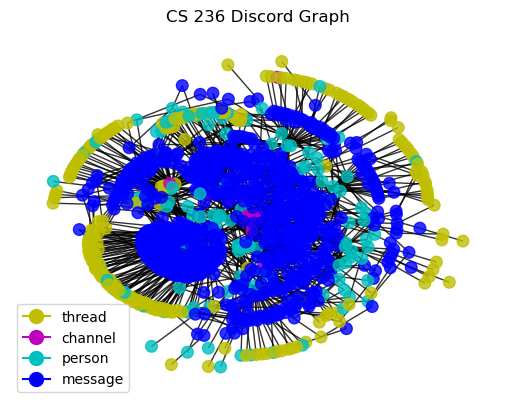

In [5]:
nodes_data, edges_data = read_data()
graph_handler = create_graph(nodes_data, edges_data, show_graph=True)

### Who was the most influential TA?

In [6]:
who_interacted_with_whom_handler = who_interacted_with_whom(graph_handler)

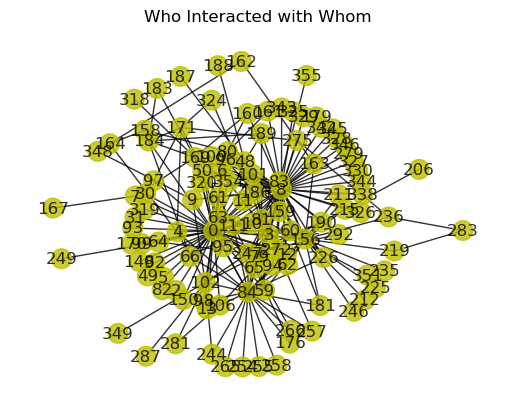

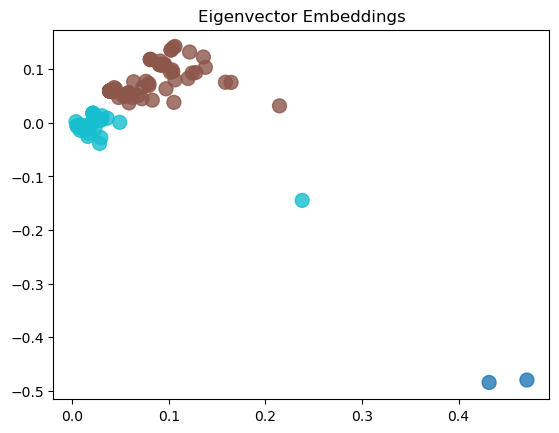

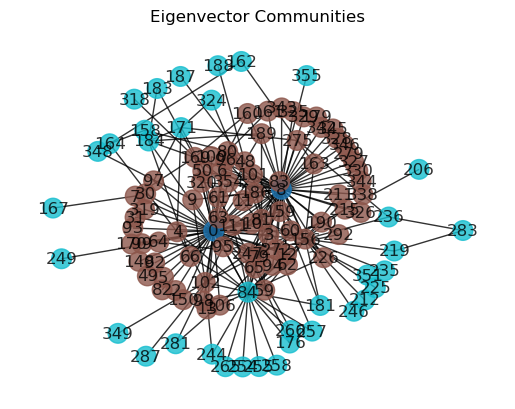

In [7]:
who_interacted_with_whom_handler.showGraph(title='Who Interacted with Whom', with_labels=True)
show_eigenvector_communities(who_interacted_with_whom_handler)

In [8]:
eigenvector_centrality(who_interacted_with_whom_handler, node_filter_val='TA')

0, TA: 0.47082382304039333
156, TA: 0.21459829335011235
169, TA: 0.11983996855087929
179, TA: 0.03871163310235631
171, TA: 0.02830611678100858
318, TA: 0.010747637868253362
164, TA: 0.008929827495846279


The TA with node type 0 is the most influential TA (I'm guessing this is Walter).  The top 3 are the following, in decreasing order: 0, 156, 169.  The other TAs seem very uninfluential (centralities close to 0).

### Who were the most influential students?

In [9]:
who_interacted_with_whom_just_students_handler = who_interacted_with_whom_just_students(graph_handler)

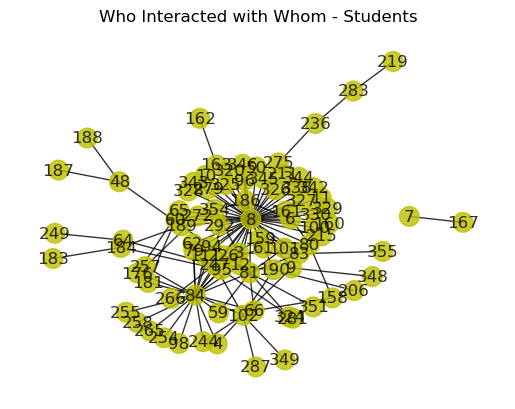

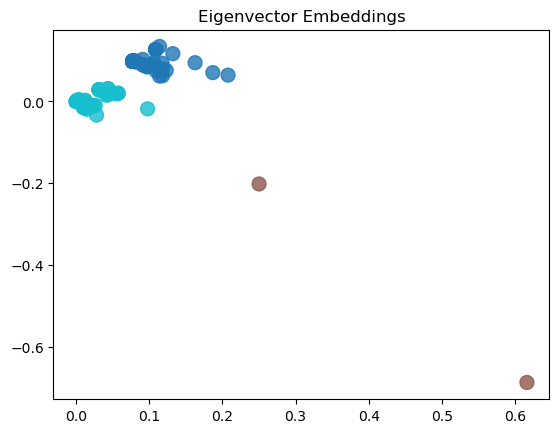

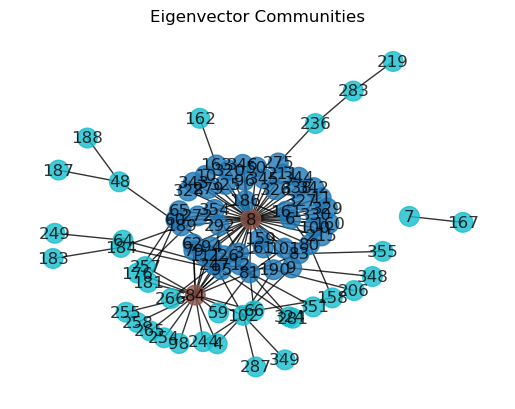

In [10]:
who_interacted_with_whom_just_students_handler.showGraph(title='Who Interacted with Whom - Students', with_labels=True)
show_eigenvector_communities(who_interacted_with_whom_just_students_handler)

In [11]:
eigenvector_centrality(who_interacted_with_whom_just_students_handler)

8, Student: 0.6162110052956096
84, Student: 0.25012466112542325
247, Student: 0.20776624345641997
81, Student: 0.18699489729011434
3, Student: 0.1627067501058233
12, Student: 0.13231872167290298
83, Student: 0.12328312156129852
159, Student: 0.11835997263937638
80, Student: 0.11823214337723437
190, Student: 0.11765191598085466
186, Student: 0.1142258769579439
95, Student: 0.11416230266965201
272, Student: 0.10957382012603264
62, Student: 0.10882821751708252
79, Student: 0.10882821751708252
94, Student: 0.10882821751708252
111, Student: 0.10882821751708252
226, Student: 0.10882821751708252
189, Student: 0.10616061517943826
61, Student: 0.1035075037069629
292, Student: 0.1035075037069629
101, Student: 0.10089820535142444
354, Student: 0.0978471490733513
102, Student: 0.09781700399531167
60, Student: 0.0966447360451028
160, Student: 0.0922601701280175
161, Student: 0.0922601701280175
6, Student: 0.09175689913117001
96, Student: 0.09175689913117001
9, Student: 0.09113364076005714
65, Stude

Student 8, by far, seemed to be the most influential.  This also makes sense based on what we saw from the projections when looking at the most influential TAs.  The top five, in decreasing order, are the following: 8, 84, 247, 81, 3.

### What types of messages did TA 0 send?

In [12]:
ta_0_messages = [message for message in edges_data[edges_data['source'] == 0]['content'] if isinstance(message, str)]
ta_0_messages_embeddings = np.array([vectorize_message(nlp, message) for message in ta_0_messages])
assert len(ta_0_messages) == len(ta_0_messages_embeddings)
ta_0_messages_embeddings.shape

(158, 300)

In [13]:
ta_0_messages

['Project Submission Question',
 "I'm feeling better so I'll be in at around 11:30",
 'Nope',
 'Will there be any TAs today?',
 'Yes, see the <#1148663286267641906> for specific hours the TAs plan on working',
 'I think I fixed all affected grades, reach out if there was a problem with yours',
 'I will do a grade merge tomorrow morning, if your grade is not in by end of day send me a DM with your netid and GitHub username',
 'Zoom has issues with copy and paste from time to time, try manually typing it in',
 'Cool, I assume people who had already taken the exam will have that accounted for later?',
 'Up to you, I used a dictionary',
 'A <-> B\nIs the same as\n(A->B) ^ (B -> A)',
 'You will not be required to show the error state unless otherwise stated in the question',
 'This, 100%',
 'Check the <#1146860399384338483>  channel',
 'Yes there will be a final\n\nCurrent plan for it is to be weighted towards the second half of the content',
 'The sand',
 'Do you mean like this:\n```\n1. a

In [19]:
ta_0_messages_embeddings_compressed = TSNE(n_components=2).fit_transform(ta_0_messages_embeddings)
print(ta_0_messages_embeddings_compressed.shape)

(158, 2)


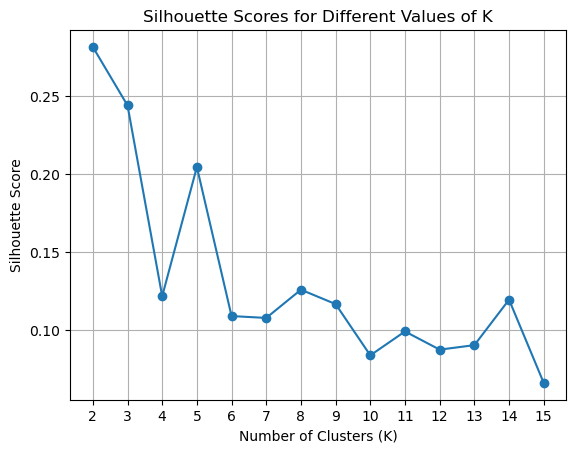

2

In [21]:
k = find_optimal_k(ta_0_messages_embeddings, show_plot=True)
k

It looks like a k of 2 is the best.

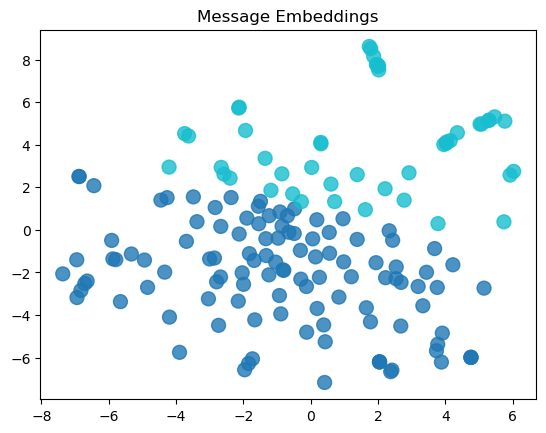

In [23]:
show_message_embeddings_communities(ta_0_messages_embeddings_compressed, None, n_clusters=k)

In [26]:
ta_0_messages_by_cluster = group_messages_by_clusters(ta_0_messages_embeddings, ta_0_messages, k)

In [27]:
# Cluster 1
ta_0_messages_by_cluster[0]

['Yes, see the <#1148663286267641906> for specific hours the TAs plan on working',
 'A <-> B\nIs the same as\n(A->B) ^ (B -> A)',
 'This, 100%',
 'Check the <#1146860399384338483>  channel',
 'Do you mean like this:\n```\n1. a v b v c v d v e v f v g\n2. not a\ntherefore: b v c v d v e v f v g\n```\n?',
 'it is also pinned int the <#1148662249871908874> channel',
 'should be at the top of the <#1148662249871908874> channel',
 'say our graph has 2 edges with weights\na->b: 5\nb->a: 4\n\nthe graph would be\n\nV = {a, b}\nE = {(a,b), (b,a)}\nw = {((a,b), 5), ((b,a), 4)}',
 'Your program will output an error message \n\nDetails on what the message looks like are on LS ->  Content -> Projects -> Project 1',
 '2 options:\n1\n```\nUse your diagram to encode the ID FSA to exclude RULES, FACTS, QUERIES, and SCHEMES as IDs\n```\n2\n```\nAdd a condition in somewhere where if the ID FSA and the FACTS, SCHEMES, RULES, or QUERIES FSA both announce that they accept preference the keyword FSA\n```',
 

^ These look more like technical messages ^

In [28]:
# Cluster 2
ta_0_messages_by_cluster[1]

['Project Submission Question',
 "I'm feeling better so I'll be in at around 11:30",
 'Nope',
 'Will there be any TAs today?',
 'I think I fixed all affected grades, reach out if there was a problem with yours',
 'I will do a grade merge tomorrow morning, if your grade is not in by end of day send me a DM with your netid and GitHub username',
 'Zoom has issues with copy and paste from time to time, try manually typing it in',
 'Cool, I assume people who had already taken the exam will have that accounted for later?',
 'Up to you, I used a dictionary',
 'You will not be required to show the error state unless otherwise stated in the question',
 'Yes there will be a final\n\nCurrent plan for it is to be weighted towards the second half of the content',
 'The sand',
 'Unfortunately no, if you submit it tommorow it would be subject to the standard late penalty',
 'Shoot me a dm and we can get it figured out. The auto grader pulls the date from your most recent submission to calculate what 

^ These look more like business and general instruction/clarification messages ^

In [29]:
print(len(ta_0_messages_by_cluster[0]), len(ta_0_messages_by_cluster[1]))

25 133


Since the second cluster is (by far) the largest and seems to contain messages around general instruction, perhaps more time could be spent improving project/assignment specs.

### What types of messages did students send?

In [30]:
student_nodes = set()

for _, row in nodes_data[['node', 'value']].iterrows():
    node_id, node_value = row['node'], row['value']
    if node_value == 'Student':
        student_nodes.add(node_id)

student_messages = [message for message in edges_data[edges_data['source'].isin(student_nodes)]['content'] if isinstance(message, str)]
student_messages_embeddings = np.array([vectorize_message(nlp, message) for message in student_messages])
assert len(student_messages) == len(student_messages_embeddings)
student_messages_embeddings.shape

(1148, 300)

In [31]:
student_messages_embeddings_compressed = TSNE(n_components=2).fit_transform(student_messages_embeddings)
print(student_messages_embeddings_compressed.shape)

(1148, 2)


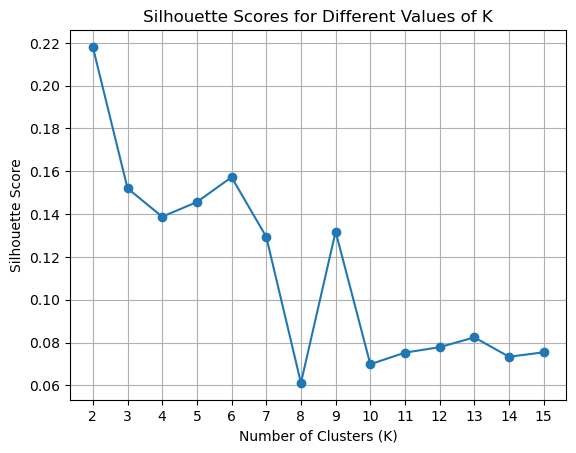

2

In [33]:
k = find_optimal_k(student_messages_embeddings, show_plot=True)
k

It looks like a k of 2 is the best.

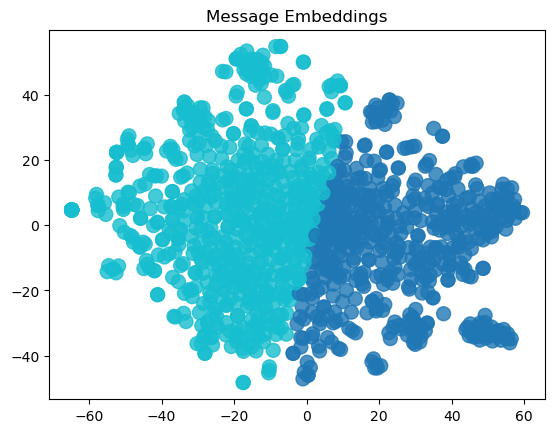

In [34]:
show_message_embeddings_communities(student_messages_embeddings_compressed, None, n_clusters=k)

In [35]:
student_messages_by_cluster = group_messages_by_clusters(student_messages_embeddings, student_messages, k)

In [36]:
# Cluster 1
student_messages_by_cluster[0]

['I hope so! That’s how I’ve done everything.',
 'Just got it, thanks!',
 "Will there still be TA's available Mon-Wed this week?",
 "I had that happen to me too. Basically it's just a weird way of saying that you need to make sure to print out your Domain.",
 'I figured it that it is actually a problem with my rules I think thanks',
 'Is there a TA email?',
 'Thanks!',
 'Where can I find TA hours?',
 '\\n',
 'Did you get it checked off with a TA as well as just submitting it?',
 'Put what you want the name of it to be in the " "',
 'I did that and then it says all my autograders are failing',
 "Yeah that's correct",
 'Are there going to be TA hours tomorrow morning?',
 "That's fine. It's what I would do",
 'Do we still have ta today?',
 "Have you checked the actual website? For me, I don't exactly know what to say because it's hard to tell if anything's happened (I don't exactly understand what's happening in the picture, but a TA probably would) unless you tell me if it's not on the a

In [37]:
# Cluster 2
student_messages_by_cluster[1]

["What is the best way to handle tokens of variable length (IDs, strings & comments)? It's easy to truncate fixed-length tokens from the file string after detection. My current plan is to add an extra output to my FSAs saying how many characters are included",
 'when you say output, do you mean an additional return object? cause you can also just make it an fsa class variable and add a getter function',
 "That's not an issue with your code, something is up on the github end",
 'I don\'t know if you ever got this fixed, but I think I fixed it by adding a + "\\n" to the end of my final output string. If you go in and look at the provided answers you\'ll see that there\'s an infernal extra space below every one.',
 "If a function has elements in its domain that are unmapped it would still be a function (assuming no inputs lead to 2+ outputs). I think that makes it a partial function. Injective doesn't have anything to do with all the domain elements being mapped so it is still injective. 

In [38]:
print(len(student_messages_by_cluster[0]), len(student_messages_by_cluster[1]))

197 951


It looks like the first cluster primarily contains responses/statements (with a few exceptions), while the second cluster primarily contains questions (with a few exceptions); the size of this cluster also isn't suprising (one would imagine that students would tend to ask questions more than give answers).

### Let's use the network structure and a GCN to get more message info - first, we'll try using community as message labels

In [39]:
message_interactions_handler = message_interactions(graph_handler)

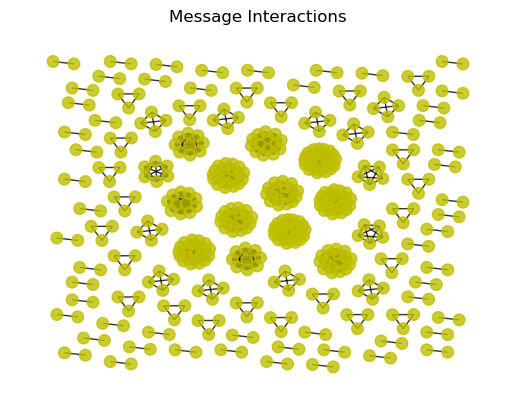

The Louvain algorithm found 104 partitions.


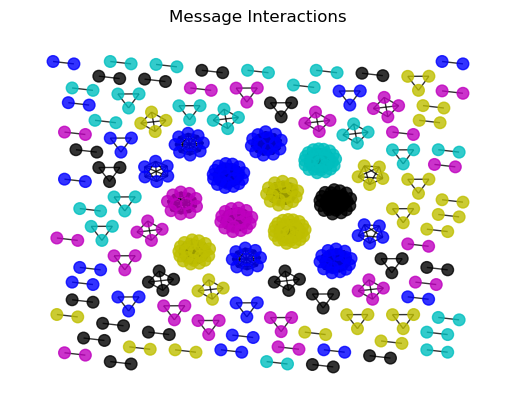

In [40]:
message_interactions_handler.showGraph(title='Message Interactions', with_labels=False)
message_interactions_handler.showLouvainCommunities(title='Message Interactions')

In [41]:
x, y = get_message_gcn_data(nlp, message_interactions_handler)
data = create_pytorch_data(message_interactions_handler.getGraph(), x, y)
adjacency_matrix = nx.adjacency_matrix(message_interactions_handler.getGraph()).astype(np.float32).toarray()
n_communities = len(message_interactions_handler.get_louvain_communities())

In [42]:
model = GCN(64, 32, 8, n_communities)
model

GCN(
  (hidden_layer_1): GCNConv(300, 64)
  (hidden_layer_2): GCNConv(64, 32)
  (hidden_layer_3): GCNConv(32, 8)
  (output_layer): Linear(in_features=8, out_features=104, bias=True)
)

In [43]:
embedding = train_model(data, model)
embedding.shape

Final loss: 0.0016990229487419128
Final accuracy: 0.8943820224719101


torch.Size([445, 8])

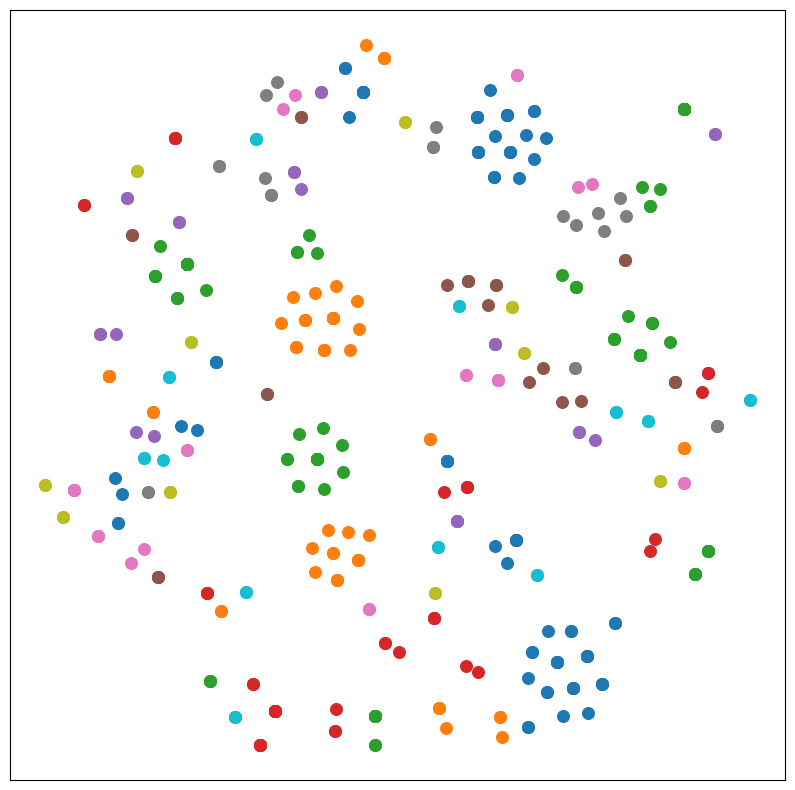

In [44]:
visualize(embedding, y)

/Users/mymac/miniforge3/envs/575/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


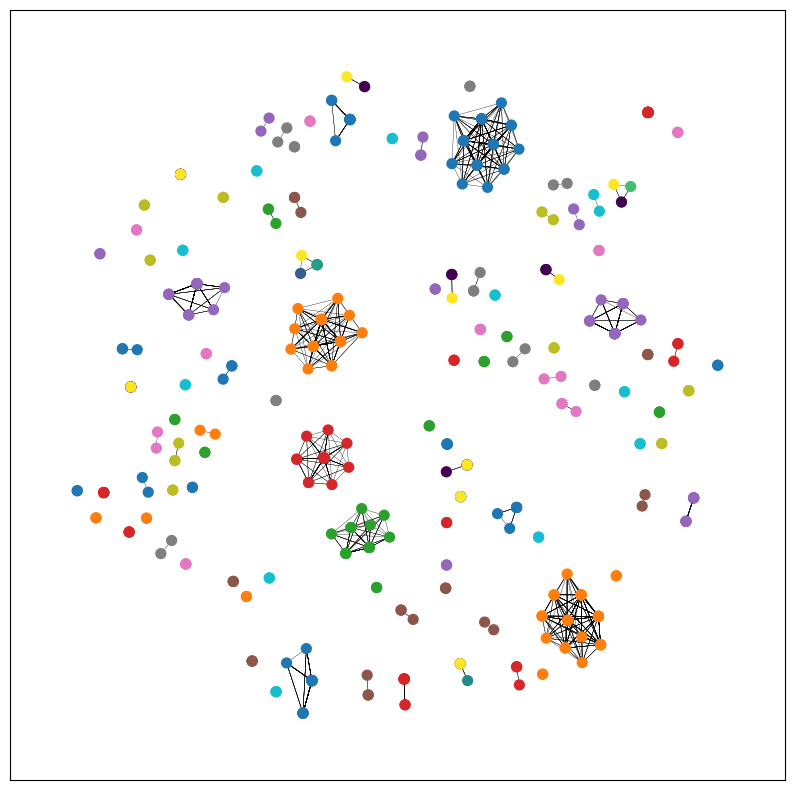

In [45]:
visualize_with_edges(message_interactions_handler, embedding)

It looks like we were able to, at least somewhat successfully, learn a two-dimensional embedding of the messages, especially for messages in large components (likely project messages).  While this might be useful for determining which channel/thread a message might belong to, it doesn't tell us as much about message content.  We'll explore this in the next section.

### Let's do the same thing (get message embeddings from a GCN), but hand-label a few messages by their "type"

In [46]:
nodes_with_messages = []

for node, attrs in message_interactions_handler.getGraph().nodes(data=True):
    assert attrs['node_type'] == 'message'
    message = attrs['node_value']
    nodes_with_messages.append((node, message))

len(nodes_with_messages)

445

In [61]:
random.sample(nodes_with_messages, int(len(nodes_with_messages) * 0.1))

[(240,
  'For hw 4 #3a are we doing the fsa for the string "strings" or just any possible string?'),
 (409,
  "Hello! I've gotten everything working for this project (I got an extension from Professor Goodrich), and ran the tests on my local machine. I committed everything to github, but nothing shows up in the Actions tab. I can't find any more info on this. Have I done something wrong?"),
 (35, 'nope, so long as it passed'),
 (207, 'pytest test.py -v --tb=short --bucket=80'),
 (206,
  "So there's a weird error I'm getting in the bucket tests of my code... ```AttributeError: 'NoneType' object has no attribute 'rstrip'``` I assume this is becuase my code is trying to return a null character in the output string which doesn't show up in my terminal, but that the bucket test doesn't like. It seems to be ocurring in the cases where the query has all strings as it's parameters (\n```DeaWoo('a','a','a','a','a','a','b')? Yes(1)\n```) for example, in test case 2. In my terminal this 'error' s

In [47]:
class_label_mapping = {0: 'Homework Question', 1: 'Clarification Response', 2: 'Error Question', 
                       3: 'Technical Question', 4: 'Response with Follow-Up', 5: 'Recommendation', 
                       6: 'Clarification Question'}

hand_labels = {240: 0, 409: 3, 35: 1, 207: 1, 206: 2, 362: 1, 129: 6, 325: 3, 291: 5, 381: 3,
               411: 4, 20: 6, 151: 3, 159: 6, 157: 4, 69: 1, 132: 5, 197: 1, 209: 6, 224: 1,
               216: 1, 68: 1, 256: 0, 378: 4, 18: 6, 398: 2, 15: 5, 149: 1, 312: 1, 360: 4,
               431: 6, 391: 1, 337: 4, 8: 1, 90: 3, 333: 2, 38: 4, 167: 4, 425: 1, 191: 3,
               4: 5, 83: 3}

In [48]:
x, y = get_message_gcn_data(nlp, message_interactions_handler, hand_labels)
data = create_pytorch_data(message_interactions_handler.getGraph(), x, y, hand_labels=hand_labels)
adjacency_matrix = nx.adjacency_matrix(message_interactions_handler.getGraph()).astype(np.float32).toarray()
n_classes = len(np.unique(y))

In [49]:
model = GCN(64, 32, 8, n_classes)
model

GCN(
  (hidden_layer_1): GCNConv(300, 64)
  (hidden_layer_2): GCNConv(64, 32)
  (hidden_layer_3): GCNConv(32, 8)
  (output_layer): Linear(in_features=8, out_features=7, bias=True)
)

In [50]:
embedding = train_model(data, model, semi_supervised=True)
embedding.shape

Final loss: 0.3058713376522064
Final accuracy: 0.07865168539325842


torch.Size([445, 8])

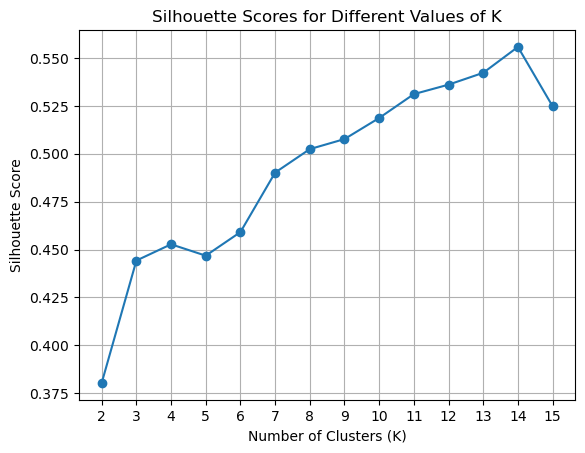

14

In [54]:
compressed_embeddings = TSNE(n_components=2).fit_transform(embedding.detach().cpu().numpy())
k = find_optimal_k(compressed_embeddings, show_plot=True)
k

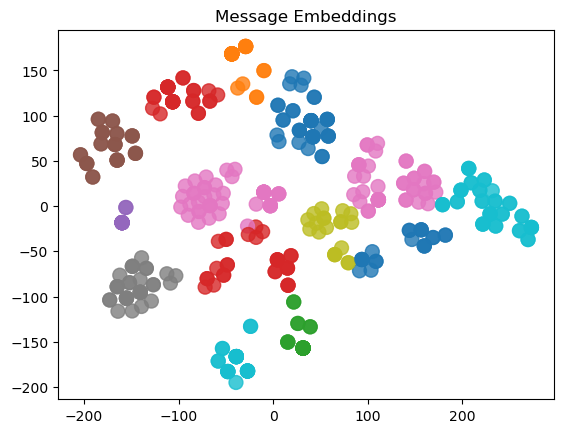

In [55]:
kmeans = get_clusters(compressed_embeddings, num_clusters=k)
show_message_embeddings_communities(compressed_embeddings, kmeans, n_clusters=k)

Even though we originally had 7 labels, k means is telling us that the GCN appeared to learn 14 clusters of embeddings, which is very interesting.  One could argue that this seems to make sense because the original labels were somewhat arbitrary, but likely gave the network a sense of how to group messages (i.e. the hand labels were a starting point for the GCN).

### What types of messages did the most influential students send?

##### Student 8

In [56]:
student_node = 8
student_message_indices = []

for node, attrs in message_interactions_handler.getGraph().nodes(data=True):
    if attrs['sender'] == student_node:
        student_message_indices.append(node)

student_message_embeddings = compressed_embeddings[student_message_indices]
student_message_embeddings.shape

(51, 2)

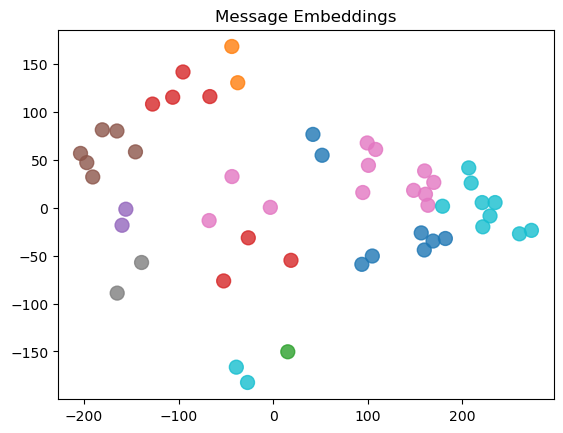

In [57]:
show_message_embeddings_communities(student_message_embeddings, kmeans, n_clusters=k)

In [58]:
print_cluster_counts(kmeans, student_message_indices, 3)

[(9, 9), (12, 9), (7, 6)]


In [59]:
print_cluster_messages(kmeans.labels_, student_message_indices, 9, message_interactions_handler.getGraph())

CLUSTER 9
---------------------------------------------------------------
he said there would be one in class on friday
---------------------------------------------------------------

---------------------------------------------------------------
I’m not sure if I 100% understand your question, but an FSA doesn’t necessarily need an error state, the idea is that if it gets through the whole string and is not in an accept state, then it is technically in an error state
---------------------------------------------------------------

---------------------------------------------------------------
yeah I did something like that. For python sets there's a difference function built in that you can use with '-'

set_A - set_B = New set that contains stuff only in A
---------------------------------------------------------------

---------------------------------------------------------------
looking at my code it seems like my sccs were already in the right order. Basically, for every scc 

These look more like responses around code strategies/approaches

In [60]:
print_cluster_messages(kmeans.labels_, student_message_indices, 12, message_interactions_handler.getGraph())

CLUSTER 12
---------------------------------------------------------------
I think in order to do a proof using resolution everything needs to be in CNF form. Perhaps that might require disjunctive syllogism? In any case, once you have CNF form (and I believe all the homework’s already give the premises in this form) you should be able to do the proof using only resolution
---------------------------------------------------------------

---------------------------------------------------------------
I heard yes
---------------------------------------------------------------

---------------------------------------------------------------
It says to do a DFS search starting at A. You can start anywhere, but your forest will look different depending on where you start
---------------------------------------------------------------

---------------------------------------------------------------
Even test 6 bucket 100 goes fast?
------------------------------------------------------------

Medium to long clarification responses without much relation to code

In [61]:
print_cluster_messages(kmeans.labels_, student_message_indices, 7, message_interactions_handler.getGraph())

CLUSTER 7
---------------------------------------------------------------
Thank you!
---------------------------------------------------------------

---------------------------------------------------------------
Did you run these commands before following the learning suite pass off instructions?
git add .
git commit -m “Message”
git push
---------------------------------------------------------------

---------------------------------------------------------------
That's biconditional and it is only True when the items on the left and right have the SAME truth values, either True-True or False-False
---------------------------------------------------------------

---------------------------------------------------------------
I got that error when I hadn’t done the git add and push stuff before running the cases on GitHub.

DId you do all these?
git add .
git commit -m “Message”
git push
---------------------------------------------------------------

-------------------------------

Shorter clarification responses, mainly arround git/technical stuff

##### Student 84

In [62]:
student_node = 84
student_message_indices = []

for node, attrs in message_interactions_handler.getGraph().nodes(data=True):
    if attrs['sender'] == student_node:
        student_message_indices.append(node)

student_message_embeddings = compressed_embeddings[student_message_indices]
student_message_embeddings.shape

(30, 2)

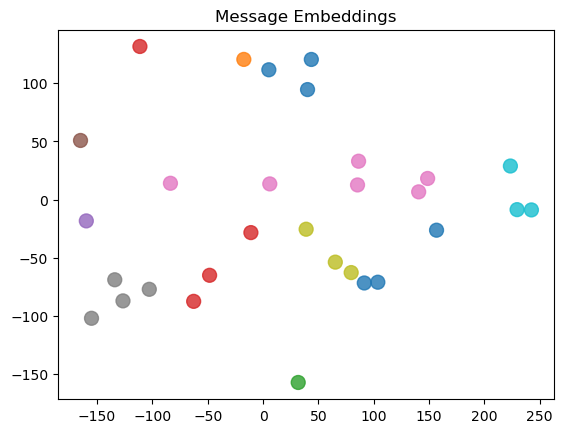

In [63]:
show_message_embeddings_communities(student_message_embeddings, kmeans, n_clusters=k)

In [64]:
print_cluster_counts(kmeans, student_message_indices, 3)

[(9, 4), (10, 4), (11, 3)]


In [115]:
print_cluster_messages(kmeans.labels_, student_message_indices, 9, message_interactions_handler.getGraph())

CLUSTER 9
---------------------------------------------------------------
Where does it say, if its raining Yvette will get wet? from what I can see there aren't any imply ones on that proof
---------------------------------------------------------------

---------------------------------------------------------------
i tried that but it keep giving me errors
---------------------------------------------------------------

---------------------------------------------------------------
The parse_datalog_program function shouldn't return anything, if you do option A on the TA help slides which i highly recommend. It just wont fail if its an accepted format.  If you do option B it should just return your datalog_program object. The datalog_program object contains all of your scheme predicates, fact predicates, rules, query predicates, and domain list. your datalog_program.to_string() returns a formatted version of all of these put together so that it looks like what is supposed to be out

These look more like responses around code strategies/approaches, with one or two questions

In [116]:
print_cluster_messages(kmeans.labels_, student_message_indices, 10, message_interactions_handler.getGraph())

CLUSTER 10
---------------------------------------------------------------
i had to put python -m in front for it to work, it might be a windows thing
---------------------------------------------------------------

---------------------------------------------------------------
why would it say that the str doesnt have a name attribute when I do scheme.name? my scheme predicates is a list of predicates so each one should have a name attribute. Also, when i do scheme. it comes up with the options of name and attribute its just the compiler that doesnt like it
---------------------------------------------------------------

---------------------------------------------------------------
Sometimes it gives that error when you run you code from anywhere except project4.py and your main function.
---------------------------------------------------------------

---------------------------------------------------------------
What part of the pseudo code is confusing?
------------------------

More responses around technical details; I wouldn't be surprised if this could be considered part of cluser 0, though these seem to be answers in the form of questions.

In [65]:
print_cluster_messages(kmeans.labels_, student_message_indices, 11, message_interactions_handler.getGraph())

CLUSTER 11
---------------------------------------------------------------
This is probably what your gonna have to do.
---------------------------------------------------------------

---------------------------------------------------------------
Your lexer in project 1 printed out the token list most likely using a to_string() to do it. In project 2 you want to make sure you are just passing in the list of tokens as a list of token objects. You may have to manipulate your project 1 code a bit
---------------------------------------------------------------

---------------------------------------------------------------
Yup
---------------------------------------------------------------



Similar to the previous two clusters

### What were the most common messages?

In [66]:
message_indices = [node for node in message_interactions_handler.getGraph().nodes]

message_embeddings = compressed_embeddings[message_indices]
message_embeddings.shape

(445, 2)

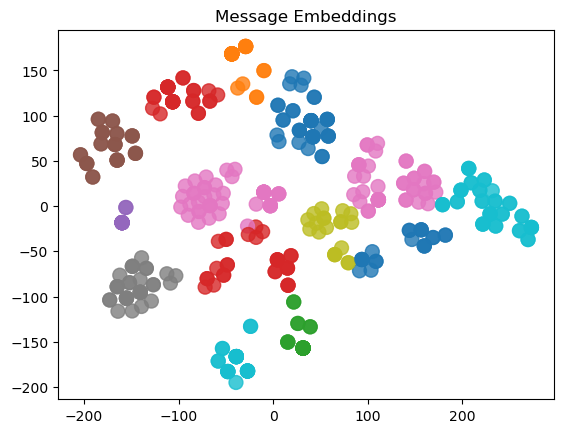

In [67]:
show_message_embeddings_communities(message_embeddings, kmeans, n_clusters=k)

In [138]:
print_cluster_counts(kmeans, message_indices, 5)

[(9, 57), (12, 46), (1, 40), (10, 36), (4, 33)]


Based on previous results, clusters 9 and 12 seem to be responses, which makes sense because the most influential students and TA have a lot of messages in cluster 9 (so there are a lot of messages in cluster 9).  Since we're interested in questions, we'll skip ahead to cluster 1.

In [140]:
print_cluster_messages(kmeans.labels_, message_indices, 1, message_interactions_handler.getGraph())

CLUSTER 1
---------------------------------------------------------------
Hi everyone, would you (hypothetically) attend a review session for lab 2?
---------------------------------------------------------------

---------------------------------------------------------------
How is it different
---------------------------------------------------------------

---------------------------------------------------------------
Excellent summary
---------------------------------------------------------------

---------------------------------------------------------------
I would suggest moving the code to print out the unique tuples to evaluate rule function. This is a good approach since the function will be reused in project 5 and we expect it to produce the same output.
---------------------------------------------------------------

---------------------------------------------------------------
You need to make an ssh key pair and register it with github
------------------------------

With some exceptions, it looks like a lot of these are general and/or instruction-related questions.

In [141]:
print_cluster_messages(kmeans.labels_, message_indices, 10, message_interactions_handler.getGraph())

CLUSTER 10
---------------------------------------------------------------
Will there be any TAs today?
---------------------------------------------------------------

---------------------------------------------------------------
Textbook pdf
---------------------------------------------------------------

---------------------------------------------------------------
Lab sessions time
---------------------------------------------------------------

---------------------------------------------------------------
Why are we making a Header class? So far it seems to me that its functionality is already described by Tuple
---------------------------------------------------------------

---------------------------------------------------------------
Are our headers and rows(tuples) supposed to be filled with predicates or strings? Is my datalog object not supposed to have predicates and should I convert the lists to strings?
-------------------------------------------------------------

It looks like these are responses and questions about getting code/error (technical) help.  We saw that student 84 had a few messages in this cluster.

In [142]:
print_cluster_messages(kmeans.labels_, message_indices, 4, message_interactions_handler.getGraph())

CLUSTER 4
---------------------------------------------------------------
The notebook is providing code for parallel and max
---------------------------------------------------------------

---------------------------------------------------------------
the answer file is correct
---------------------------------------------------------------

---------------------------------------------------------------
Some things to be aware of:

There will not be a lab session for this project, and you must complete it in 2 parts.

5a is entirely written. After finishing it you may turn it in on learningsuite. If you want more immediate feedback, come into the TA lab to get it graded by hand. You can do this as many times as needed to get full credit.

5b is writing code to perform the same computation. This project will not be accepted late, becuase it is due the last day of classes. If you do not get it turned in on or before the due date you will not get credit.
------------------------------

It looks like there are a lot of implementation-related questions (and a few suggestions) in this cluster

### What types of messages did the most influential TA send?

In [70]:
ta_node = 0
ta_message_indices = []

for node, attrs in message_interactions_handler.getGraph().nodes(data=True):
    if attrs['sender'] == ta_node:
        ta_message_indices.append(node)

ta_message_embeddings = compressed_embeddings[ta_message_indices]
ta_message_embeddings.shape

(66, 2)

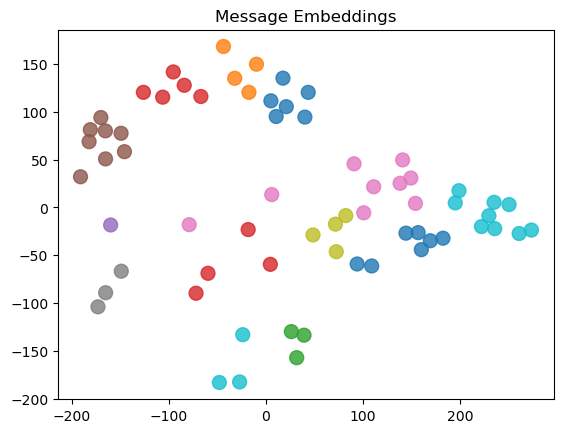

In [71]:
show_message_embeddings_communities(ta_message_embeddings, kmeans, n_clusters=k)

In [131]:
print_cluster_counts(kmeans, ta_message_indices, 3)

[(9, 11), (12, 10), (7, 8)]


These are the same clusters as the most influential student; however, let's still examine the messages out of curiousity

In [132]:
print_cluster_messages(kmeans.labels_, ta_message_indices, 9, message_interactions_handler.getGraph())

CLUSTER 9
---------------------------------------------------------------
Cool, I assume people who had already taken the exam will have that accounted for later?
---------------------------------------------------------------

---------------------------------------------------------------
You will not be required to show the error state unless otherwise stated in the question
---------------------------------------------------------------

---------------------------------------------------------------
Follow this guide:
https://discord.com/channels/1049410982167974018/1148662249871908874/1153838202172477500

No need to meet with a TA
---------------------------------------------------------------

---------------------------------------------------------------
A newline character does not make a string undefined
---------------------------------------------------------------

---------------------------------------------------------------
Can you send that to cs236ta@cs.byu.edu

Als

These look more like responses around code strategies/approaches

In [133]:
print_cluster_messages(kmeans.labels_, ta_message_indices, 12, message_interactions_handler.getGraph())

CLUSTER 12
---------------------------------------------------------------
Yes there will be a final

Current plan for it is to be weighted towards the second half of the content
---------------------------------------------------------------

---------------------------------------------------------------
Which case is it failing? Which token? Which function is failing?
---------------------------------------------------------------

---------------------------------------------------------------
seems like a reflexive reaction
---------------------------------------------------------------

---------------------------------------------------------------
nope, so long as it passed
---------------------------------------------------------------

---------------------------------------------------------------
I thought this was in the room where class normally is but I guess not. Where are the help sessions?
---------------------------------------------------------------

--------------

Medium to long clarification responses without much relation to code

In [134]:
print_cluster_messages(kmeans.labels_, ta_message_indices, 7, message_interactions_handler.getGraph())

CLUSTER 7
---------------------------------------------------------------
Up to you, I used a dictionary
---------------------------------------------------------------

---------------------------------------------------------------
A <-> B
Is the same as
(A->B) ^ (B -> A)
---------------------------------------------------------------

---------------------------------------------------------------
For anyone experiencing a similar issue make sure that you are in the same directory as the code when you run the commands as well
---------------------------------------------------------------

---------------------------------------------------------------
yes
---------------------------------------------------------------

---------------------------------------------------------------
A row should contain a list of strings

A header should contain a list of strings

A Predicate has 2  fields, a name and a list of parameters

You should have a way to convert a 'scheme' Predicate into a

Shorter clarification responses, mainly technical in nature

### Out of curiousity, how much different are the message embeddings from a traditional autoencoder?

In [73]:
class Autoencoder(Module):
    def __init__(self, in_dimension):
        super(Autoencoder, self).__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(in_dimension, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 8)
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(8, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, in_dimension)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

def get_message_autoencoder_data(nlp, handler: graphHandler) -> np.array:
    graph = handler.getGraph()
    x = []

    for node, attrs in graph.nodes(data=True):
        assert attrs['node_type'] == 'message'
        message = attrs['node_value']
        x.append(vectorize_message(nlp, message))

    return np.array(x)

def train_autoencoder(data, model, n_epochs: int = 1000):
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    def _train(data):
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data)
        loss.backward()
        optimizer.step()

        return loss

    for epoch in range(n_epochs):
        loss = _train(data)

    print(f'Final loss: {loss.item()}')

In [74]:
x = get_message_autoencoder_data(nlp, message_interactions_handler)

In [75]:
model = Autoencoder(x.shape[-1])
train_autoencoder(Tensor(x), model)

Final loss: 0.37598058581352234


In [76]:
with torch.no_grad():
    model.eval()
    message_embeddings = model.encoder(Tensor(x)).numpy()

message_embeddings.shape

(445, 8)

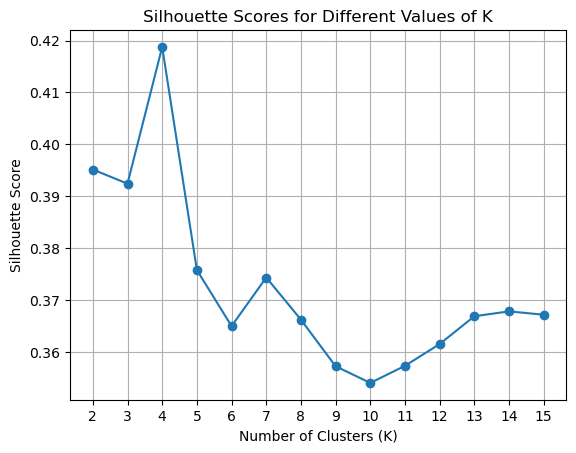

4

In [82]:
compressed_embeddings = TSNE(n_components=2).fit_transform(message_embeddings)
k = find_optimal_k(compressed_embeddings, show_plot=True)
k

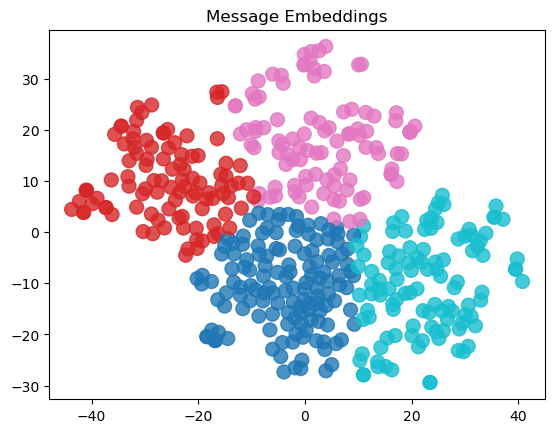

In [83]:
kmeans = get_clusters(compressed_embeddings, num_clusters=k)
show_message_embeddings_communities(compressed_embeddings, kmeans, n_clusters=k)

It appears that the autoencoder learned something similar as the GCN, though there are only 4 clusters now instead of 14; additionally, the clusters are not as clearly separated as they were with the GCN.  This does not seem very suprising because the GCN uses extra information from the graph, so it is probably learning additional information.  However, this approach was admittedly more straightforward and did not require hand labels, and it appears that something at least somewhat useful about message types was learned.